In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
%matplotlib inline

# Week 5 Notes
### Numerical Integration - Simulations from ODEs

## Basic Example: Kinematics

Today we will look at how we can simulate the motion of a particle under the influence of some central force, $F$. To start off, we will consider a projectile launched from earth with no air resistance. This is the basic kinematics problem that can be solved exactly as you did in 1st year Physics. We will apply a numerical integrator to solve it numerically.

Though not useful for this problem, numerical integrators are useful for solving many problems in Physics that do not have analytical solutions. This simple problem will however allow me to demonstrate many of the important parts without the difficulty of a more complicated problem. 

Here are the parameters we need for our problem. The projectile is launched with speed $v$ and angle $\theta$:

$$ \vec F = (0, -mg) $$

$$ \vec v = (v \cos(\theta), v \sin(\theta)) $$

The we will apply Newton's Second Law to write the equation of motion:

$$ \vec F = m \vec a = m \vec{\ddot r}$$

And $\vec F/m = (0, -g)$. So we can write a second order differential equation:

$$ \vec{\ddot r} = (0, -g) $$

Or in component form:

$$ \ddot x = 0 $$

$$ \ddot y = -g $$

Clearly integrating both of these gives us the kinematics equations (you can check this is you want), but we want to solve them numerically. To do this, we use finite differences as follows. I will use the y component for example but the same follows for x:

$$ \ddot y = \dot v_y = -g $$

So

$$ \mathop{dv_y} = -g \mathop{dt} $$

And letting the differencials become differences:

$$ \Delta v_y = -g \Delta t $$

Or

$$ v_{yf} - v_{yi} = -g \Delta t \implies v_{yf} = v_{yi} - g \Delta t $$

Then we need to make an assumption. We assume that for a $\Delta t$ sufficiently small, $v_y$ can be modelled as a constant. We can then apply the same steps as above to the equation for position and find:

$$ \Delta y = v_y \Delta t \implies y_f = y_i + v_y\Delta t$$

So in general, we write:

$$ v_{\delta f} = v_{\delta i} + a_\delta \Delta t$$

$$ r_{\delta f} = r_{\delta i} + v_\delta \Delta t$$

Where $\delta$ is the compoent (ie $x$, $y$, $z$) and $a$, $v$ are the acceleration and velocity at the start of the step.

Then we will just code these equations and the will have the most basic method: The Euler method. There are many ways to code it but I will try to make it as general as possible to allow us to modify it later when we want to implement a more complicated method.

In [9]:
def accel():
    """
    We start with a function for our acceleration. In this case,
    the acceleration is independent of the position or velocity
    so we don't need any parameters.
    """
    g = 9.810
    return (0, -g)

In [10]:
def euler(r, v, dt):
    """
    The euler method function takes in a vector of the components
    of the position and velocity. It also takes the desired timestep,
    dt. It will change the position and velocity but will not return
    anything.
    """
    # Here it is coded specifically for 2D so you can see what is happening.
    # Later I will gneralize it.
    
    # Calcualate the force
    ax, ay = accel()
    
    # Update the position coordinates
    r[0] += v[0] * dt
    r[1] += v[1] * dt
    
    # Update the velocity coordinates
    v[0] += ax * dt
    v[1] += ay * dt

In [11]:
def integrate(v, theta, dt):
    # The initial components of velocity
    vx = v * np.cos(theta)
    vy = v * np.sin(theta)
    v = np.array([vx, vy])
    
    # Start from the origin
    r = np.array([0., 0.])
    
    x_res = []
    y_res = []
    t_res = []
    
    t = 0
    
    while r[1] >= 0.:
        x_res.append(r[0])
        y_res.append(r[1])
        t_res.append(t)
        t += dt
        
        euler(r, v, dt)
        
    return x_res, y_res, t_res

In [12]:
x, y, t = integrate(100, np.pi / 4, 0.01)

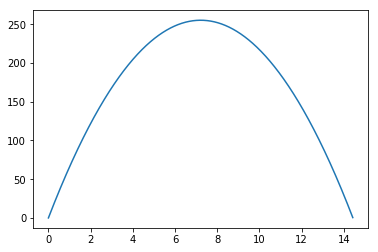

In [13]:
plt.plot(t, y)

## More complicated example: Planet orbiting a fixed star

Consider the problem of two gravitationally bound bodies rotating the center of mass. For this example we will take the case of a star and a planet. Then since $m_* >> m_p$, we can consider that the star is fixed. For convenience, we will let the star be fixed at the origin.

To start off, we must consider the equations of motion. We need to apply Newton's Law of Gravitation.

$$ \frac{F_{*p}}{m_p} = a_p = -\frac{Gm_*}{r^2} \hat r$$ 

Then let's make a variable substitution and let $Gm_* = \mu$.

$$ a_p = -\frac{\mu}{r^2} \hat r$$

We will work in cartesian coordinates so:

$$ \hat x = \frac{x}{|r|} \ \ \ \ \hat y = \frac{y}{|r|}$$

And we will choose the units of G and the mass of the star such that $\mu = 1$ in our non-dimensional solar system.

Then:

$$ a_{px} = -\frac{\mu x}{|r|^3} $$ 

Is the acceleration of the planet from the force applied by the star. The same again follows for the y component by replacing the x with y.

Now all that is left is to establish the initial conditions. We need to define the initial position, $\vec r$ and the initial velocity, $\vec v$. 

Since our system is non-dimensional, we choose to start with an orbit of radius 1. Then choosing the central body to be at the origin we must choose the planet somewhere around the unit circle. For convenience, we choose:

$$ r_p = (1, 0) $$

Since we want to start on a circular velocity, we are starting along the x axis so the velocity should be purely in the y direction. Let's choose it to be defined as a the keplarian velcity in the CCW direction. Then:

$$ v_p = \left(0, \frac{1}{\sqrt{r}}\right) = (0, 1) $$

And that is now averything that we need for a well posed question. So now we will adapt out code above to be able to solve this.

In [14]:
def accel(r):
    """
    Acceleration calculated from position vector of the two bodies
    and the value of mu for the body other than the one we are calculating
    the acceleration of. We will let r1 represent the position of the body
    we want to calculate the acceleration of.
    """
    r2 = r[0]**2 + r[1]**2
    denom = 1/(r2 * np.sqrt(r2))
    
    return [-r[0] * denom, -r[1] * denom]

In [15]:
def euler(r, v, dt):
    # Calcualate the force
    ax, ay = accel(r)
    
    # Update the position coordinates
    r[0] += v[0] * dt
    r[1] += v[1] * dt
    
    # Update the velocity coordinates
    v[0] += ax * dt  
    v[1] += ay * dt

In [16]:
def integrate(dt, t_end):
    r = [1., 0]
    v = [0, 1.]
    
    x_res = []
    y_res = []
    t_res = []
    
    t = 0
    
    while t <= t_end:
        x_res.append(r[0])
        y_res.append(r[1])
        t_res.append(t)
        t += dt
        
        euler(r, v, dt)
        
    return x_res, y_res, t_res

In [25]:
x, y, t = integrate(0.01, 10 * 2 * np.pi)

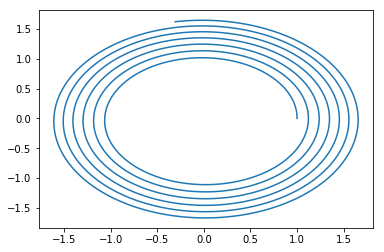

In [26]:
plt.plot(x, y)